Model created for the Neural Networks course at CESAR School.

Students:
- Breno Araújo
- Filipe Pontes

# Data Preprocessing

In [1]:
!rm -rf neural-network-dogs/ val/ train/

In [2]:
!git clone https://github.com/breno-mendes/neural-network-dogs.git

Cloning into 'neural-network-dogs'...
remote: Enumerating objects: 397, done.
remote: Counting objects: 100% (397/397), done.
remote: Compressing objects: 100% (393/393), done.
remote: Total 397 (delta 4), reused 396 (delta 3), pack-reused 0
Receiving objects: 100% (397/397), 14.37 MiB | 25.59 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [3]:
import os
import shutil

base_dir = "neural-network-dogs/dataset"
train_dir = "train"
val_dir = "val"

# Create training and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Create directories for each dog breed
dog_breeds = ["dachshund", "golden", "lulu", "pinscher", "pitbull"]

for breed in dog_breeds:
    os.makedirs(os.path.join(train_dir, breed), exist_ok=True)
    os.makedirs(os.path.join(val_dir, breed), exist_ok=True)


In [4]:
for breed in dog_breeds:
    source_dir = os.path.join(base_dir, breed)
    train_destination = os.path.join(train_dir, breed)
    val_destination = os.path.join(val_dir, breed)

    # Moves the first 60 images of each breed to the training folder
    for i in range(1, 61):
        source_file = f"{source_dir}/{breed}_{i}.jpg"
        train_file = f"{train_destination}/{breed}_{i}.jpg"
        shutil.move(source_file, train_file)

    # Moves the remaining 15 images to the validation folder
    for i in range(61, 76):
        source_file = f"{source_dir}/{breed}_{i}.jpg"
        val_file = f"{val_destination}/{breed}_{i}.jpg"
        shutil.move(source_file, val_file)


# Loading the Data

In [5]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

In [6]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

chosen_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean_nums, std_nums)
    ]),
}

data_dir = './'  # Current folder where training and validation directories were created

chosen_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), chosen_transforms[x])
    for x in ['train', 'val']
}

dataloaders = {
    x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size=4, shuffle=True, num_workers=2)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(chosen_datasets[x]) for x in ['train', 'val']}
class_names = chosen_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
chosen_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 300
     Root location: ./train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(256, 256), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 75
     Root location: ./val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [ ]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7c479d446d10>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7c479d446c80>}

In [ ]:
print(dataset_sizes)
print(class_names)

{'train': 300, 'val': 75}
['dachshund', 'golden', 'lulu', 'pinscher', 'pitbull']


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

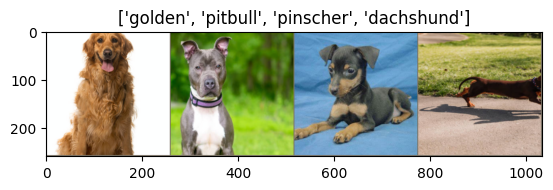

In [20]:
# Grab some of the training data to visualize
inputs, classes = next(iter(dataloaders['train']))

# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Setting up a Pretrained Model

In [ ]:
res_mod = models.resnet34(pretrained=True)
num_ftrs = res_mod.fc.in_features
res_mod.fc = nn.Linear(num_ftrs, 5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for name, child in res_mod.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [ ]:
for name, child in res_mod.named_children():
    if name in ['layer3', 'layer4']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

res_mod = res_mod.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(filter(lambda x: x.requires_grad, res_mod.parameters()), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss = 0.0
    f1_score_val = 0.0
    precision = 0.0
    recall = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()

            current_loss = 0.0
            current_corrects = 0
            all_preds = []
            all_labels = []

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc.item()))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                loss = epoch_loss
                f1_score_val = f1_score(all_labels, all_preds, average='weighted')
                precision = precision_score(all_labels, all_preds, average='weighted')
                recall = recall_score(all_labels, all_preds, average='weighted')
                best_model_wts = copy.deepcopy(model.state_dict())

            # Stores training and validation metrics
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                scheduler.step()
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Melhor Acurácia: {:.4f}'.format(best_acc))
    print('Loss: {:.4f}'.format(loss))
    print('F1-Score: {:.4f}'.format(f1_score_val))
    print('Recall: {:.4f}'.format(recall))
    print('Precisão: {:.4f}'.format(precision))

    model.load_state_dict(best_model_wts)
    return model

# Visualization

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
base_model = train_model(res_mod, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 1.1927 Acc: 0.4833
val Loss: 0.1792 Acc: 1.0000
Epoch 1/9
----------
train Loss: 0.6362 Acc: 0.7967
val Loss: 0.0648 Acc: 1.0000
Epoch 2/9
----------
train Loss: 0.5137 Acc: 0.8367
val Loss: 0.0469 Acc: 1.0000
Epoch 3/9
----------
train Loss: 0.5388 Acc: 0.8033
val Loss: 0.0467 Acc: 0.9867
Epoch 4/9
----------
train Loss: 0.5449 Acc: 0.8200
val Loss: 0.0423 Acc: 0.9867
Epoch 5/9
----------
train Loss: 0.4498 Acc: 0.8500
val Loss: 0.0383 Acc: 1.0000
Epoch 6/9
----------
train Loss: 0.5243 Acc: 0.8167
val Loss: 0.0351 Acc: 1.0000
Epoch 7/9
----------
train Loss: 0.4284 Acc: 0.8900
val Loss: 0.0375 Acc: 1.0000
Epoch 8/9
----------
train Loss: 0.5216 Acc: 0.8067
val Loss: 0.0448 Acc: 1.0000
Epoch 9/9
----------
train Loss: 0.3764 Acc: 0.8900
val Loss: 0.0457 Acc: 0.9867
Training complete in 25m 47s
Melhor Acurácia: 1.0000
Loss: 0.1216
F1-Score: 1.0000
Recall: 1.0000
Precisão: 1.0000


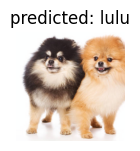

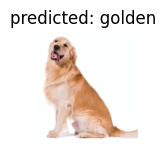

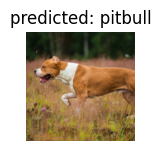

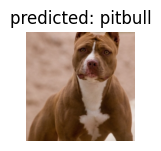

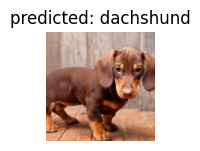

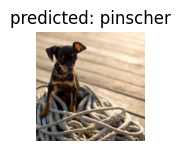

In [ ]:
visualize_model(base_model)

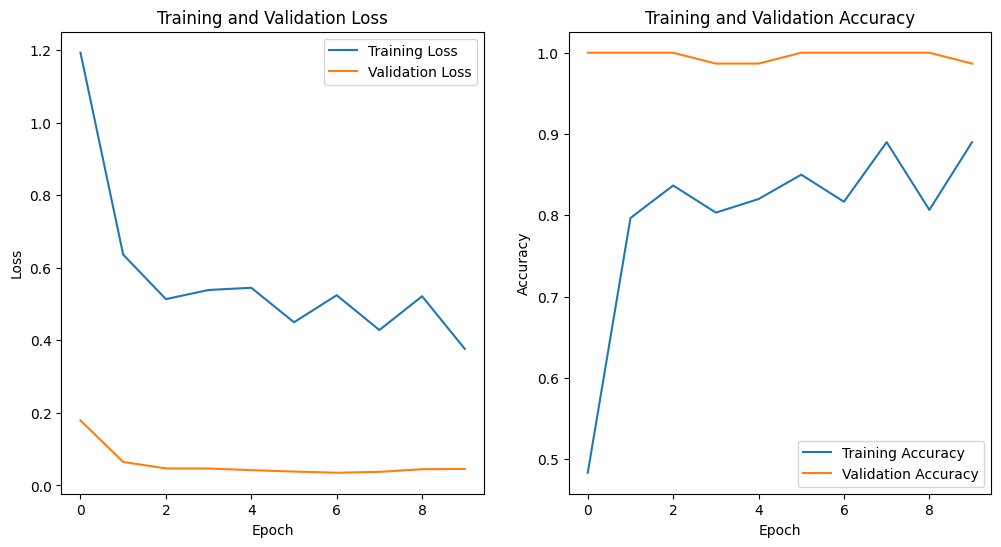

In [ ]:
# After training, plot the training and validation curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.show()

# Fixed Feature Extractor

In [ ]:
# Setting up the model
# Note that the parameters of imported models are set to requires_grad=True by default

res_mod = models.resnet34(pretrained=True)
for param in res_mod.parameters():
    param.requires_grad = False

num_ftrs = res_mod.fc.in_features
res_mod.fc = nn.Linear(num_ftrs, 5)

res_mod = res_mod.to(device)
criterion = nn.CrossEntropyLoss()

# Here's another change: instead of all parameters being optimized
# only the params of the final layers are being optimized

optimizer_ft = optim.SGD(res_mod.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 79.2MB/s]


In [ ]:
for name, child in res_mod.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [ ]:
for name, child in res_mod.named_children():
    if name in ['layer3', 'layer4']:
        print(name + 'has been unfrozen.')
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

layer3has been unfrozen.
layer4has been unfrozen.


In [ ]:
optimizer_conv = torch.optim.SGD(filter(lambda x: x.requires_grad, res_mod.parameters()), lr=0.001, momentum=0.9)

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [ ]:
base_model = train_model(res_mod, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 1.1817 Acc: 0.5333
val Loss: 0.2135 Acc: 0.9600
Epoch 1/9
----------
train Loss: 0.5962 Acc: 0.8167
val Loss: 0.0919 Acc: 0.9733
Epoch 2/9
----------
train Loss: 0.4614 Acc: 0.8600
val Loss: 0.0674 Acc: 0.9733
Epoch 3/9
----------
train Loss: 0.5950 Acc: 0.7900
val Loss: 0.0596 Acc: 0.9733
Epoch 4/9
----------
train Loss: 0.4398 Acc: 0.8600
val Loss: 0.0371 Acc: 1.0000
Epoch 5/9
----------
train Loss: 0.3309 Acc: 0.9133
val Loss: 0.0367 Acc: 1.0000
Epoch 6/9
----------
train Loss: 0.4004 Acc: 0.8733
val Loss: 0.0256 Acc: 1.0000
Epoch 7/9
----------
train Loss: 0.3629 Acc: 0.8700
val Loss: 0.0646 Acc: 0.9867
Epoch 8/9
----------
train Loss: 0.4021 Acc: 0.8767
val Loss: 0.0404 Acc: 0.9867
Epoch 9/9
----------
train Loss: 0.3363 Acc: 0.8933
val Loss: 0.0477 Acc: 0.9867
Training complete in 16m 22s
Melhor Acurácia: 1.0000
Loss: 0.0120
F1-Score: 1.0000
Recall: 1.0000
Precisão: 1.0000


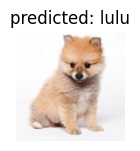

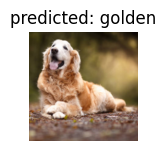

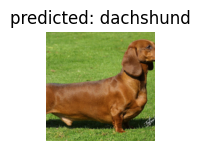

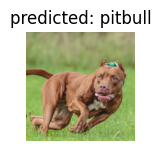

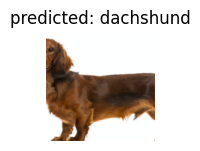

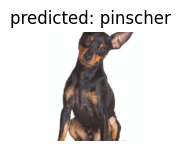

In [ ]:
visualize_model(base_model)

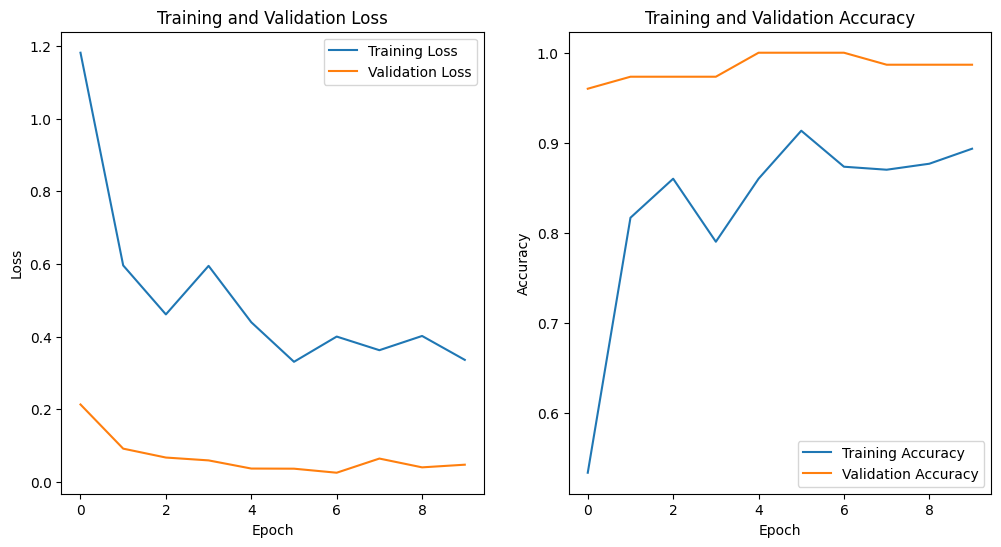

In [ ]:
# After training, plot the training and validation curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.show()

# Saving the Model

In [ ]:
torch.save(base_model.state_dict(), "dog_classification_model.pth")

In [ ]:
loaded_model = models.resnet34(pretrained=False)
num_ftrs = loaded_model.fc.in_features
loaded_model.fc = nn.Linear(num_ftrs, 5)
loaded_model.load_state_dict(torch.load("dog_classification_model.pth"))
loaded_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  